The forward state dynamics are
\begin{align}
X_{t + \Delta t} &= X_t + q_{t} \Delta t - (Z_{t + \Delta t} - Z_t)\\
Y_{t + \Delta t} &= Y_t + (-\beta Y_t + \lambda q_t) \Delta t \\
Z_{t + \Delta t} &= Z_t - \theta Z_t \Delta t + \sigma (W_{t+\Delta t} - W_t).
\end{align}

# Core functions

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display
from sklearn.linear_model import LinearRegression

speed_up_factor = 10 #set =1 for pretty plots, =10 for fast experiments

thetas = [0.0, 1.0, -1.0]
flow_map = pd.DataFrame({'parameter scans': ['martingale in-flow', 'reversal in-flow', 'momentum in-flow'], 'theta': thetas})

pal = sns.color_palette("tab10")
blueHex, orangeHex, greenHex, redHex = pal.as_hex()[0:4]
oliveHex = pal.as_hex()[8]

def generate_parameters(name='baseline', y=[0.0], z=[0.1], lamb=[0.2], beta=[8.0], eps=[1e-2], theta=[0.0], sigma=[0.1]):
    param_lists = {
        'y': y,
        'z': z,
        'lamb': lamb,
        'beta': beta,
        'eps': eps,
        'theta': theta,
        'sigma': sigma
    }
    param_combinations = list(itertools.product(*param_lists.values()))
    df = pd.DataFrame(param_combinations, columns=param_lists.keys())
    df['name'] = name
    return df

def add_auxiliary_variables(parameters):
    parameters['teps'] = parameters['eps'] * parameters['beta'] / (2 * parameters['lamb'])
    parameters['kappa'] = parameters['beta'] * np.sqrt(1 + 1/parameters['teps'])
    return parameters

def add_time_grid(parameters, T = 1.0, N = 200):
    parameters['param_id'] = parameters.index
    ts = np.linspace(0, T, N + 1)  # time grid
    dt = ts[1] - ts[0]  # time step
    num_rows = len(parameters) * len(ts)
    num_cols = len(parameters.columns)
    data = np.empty((num_rows, num_cols + 1), dtype=object)
    
    # Handle numerical and string columns separately
    numerical_columns = parameters.select_dtypes(include=[np.number]).columns.tolist()
    string_columns = parameters.select_dtypes(include=[object]).columns.tolist()
    data[:, :len(numerical_columns)] = np.repeat(parameters[numerical_columns].values, len(ts), axis=0)
    data[:, len(numerical_columns):len(numerical_columns)+len(string_columns)] = np.repeat(parameters[string_columns].values, len(ts), axis=0)
    data[:, -1] = np.tile(ts, len(parameters))
    
    df = pd.DataFrame(data, columns=numerical_columns+string_columns+['time'])
    
    # Convert numerical columns back to numeric type
    df[numerical_columns+['time']] = df[numerical_columns+['time']].apply(pd.to_numeric, errors='coerce')
    df['taus'] = T - df['time']
    return df, T, N, dt

def add_helper_variables(df, T):
    df['tfs'] = -(1/df['beta'] - 1/(df['kappa'] + df['beta'])) * np.exp(-df['kappa'] * df['taus']) - (1 / df['beta'] + 1 / (df['kappa'] - df['beta']))
    df['tgs'] = df['tfs'] / df['lamb'] - (1 + np.exp(-df['kappa'] * df['taus'])) * df['taus'] / df['lamb'] + 2 / (df['lamb'] * df['kappa']) * (1 - np.exp(-df['kappa'] * df['taus']))
    df['tfs0'] = -(1/df['beta'] - 1/(df['kappa'] + df['beta'])) * np.exp(-df['kappa'] * T) - (1 / df['beta'] + 1 / (df['kappa'] - df['beta']))
    df['tgs0'] = df['tfs0'] / df['lamb'] - (1 + np.exp(-df['kappa'] * T)) * T / df['lamb'] + 2 / (df['lamb'] * df['kappa']) * (1 - np.exp(-df['kappa'] * T))
    df['r'] = -df['tfs0'] - df['lamb']*df['tgs0']
    df['J0'] = df['tgs0']* df['y'] - df['tfs0']*np.exp(-df['theta']*T)*df['z'] / df['r']
    df['ds'] =  (
        np.exp(df['kappa']*df['taus']) * (1/(df['kappa']-df['beta']) * (1/(df['kappa']-df['beta']) + 1/df['beta'] - 1/df['kappa']) + 1/(df['beta']*df['kappa']))
        + np.exp(-df['kappa']*df['taus']) * (1/(df['kappa']+df['beta']) * (-1/(df['kappa']+df['beta']) + 1/df['beta'] + 1/df['kappa']) + 1/(df['beta']*df['kappa']))
        + df['taus'] * np.exp(df['kappa']*df['taus']) / (df['kappa']-df['beta'])
        + df['taus'] * np.exp(-df['kappa']*df['taus']) / (df['kappa']+df['beta'])
        + 4 * df['teps'] / (df['beta']*df['kappa'])
    )
    df['fs'] = df['tfs'] * (np.exp(df['kappa']*df['taus']) - 1) / df['ds']
    df['gs'] = df['tgs'] * (np.exp(df['kappa']*df['taus']) - 1) / df['ds']
    df['hs'] = df['fs'] * (1 - np.exp(-df['theta']*df['taus']))
    return df, T

def reshape_time_grid(df):
    df = df.reset_index(drop=True).select_dtypes(include=np.number)
    # Group the DataFrame by 'id'
    grouped = df.groupby('param_id')
    # Add a column for the tensor index
    df['index'] = grouped.cumcount()
    # Set 'id' and 'index' as a multi-index for the rows
    df = df.set_index(['index', 'param_id'])

    # Unstack the 'id' level of the multi-index
    tensor = df.unstack('index')

    # Get the number of unique 'id', 'index', and the remaining columns
    num_ids = df.index.get_level_values('param_id').nunique()
    num_indices = df.index.get_level_values('index').nunique()
    num_columns = len(df.columns)

    # Reshape the tensor into a 3D array
    tensor_array = tensor.values.reshape(num_ids, num_columns, num_indices)
    tensor_array = np.swapaxes(tensor_array, 1, 2)
    column_names = df.columns.tolist()

    return tensor_array, column_names

def array_to_df(arr, variable_name):
    n_samples, n_params, n_times = arr.shape
    df = pd.DataFrame({
        'sample_id': np.repeat(np.arange(n_samples), n_params * n_times),
        'param_id': np.tile(np.repeat(np.arange(n_params), n_times), n_samples),
        'time': np.tile(np.arange(n_times), n_samples * n_params),
        variable_name: arr.flatten()
    })
    return df

def simulate_path(df, dt, N, nSamples=1000, nShocks = 20):
    dWs = np.sqrt(dt) * np.random.randn(nSamples, N)
    Ws = np.concatenate((np.zeros((nSamples, 1)), np.cumsum(dWs, axis=1)), axis=1)

    # Reshape the DataFrame into a 3D tensor
    tensor_array, column_names = reshape_time_grid(df)
    c2i = {name: index for index, name in enumerate(column_names)}
    n_ids, n_indices, n_columns = tensor_array.shape

    Xs = np.zeros((nSamples, n_ids, n_indices))
    Ys = np.zeros((nSamples, n_ids, n_indices))
    Zs = np.zeros((nSamples, n_ids, n_indices))
    qs = np.zeros((nSamples, n_ids, n_indices))

    Xs[:, :, 0] = tensor_array[:, 0, c2i['J0']].reshape(1, n_ids) - tensor_array[:, 0, c2i['z']].reshape(1, n_ids)
    Ys[:, :, 0] = tensor_array[:, 0, c2i['y']].reshape(1, n_ids) + tensor_array[:, 0, c2i['lamb']].reshape(1, n_ids)*tensor_array[:, 0, c2i['J0']].reshape(1, n_ids)
    Zs[:, :, 0] = tensor_array[:, 0, c2i['z']].reshape(1, n_ids)
    
    dWs = np.zeros((nSamples, N))
    waitPeriod = N // nShocks
    for i in range(N):
        dWs[:, i] = Ws[:, i+1] - Ws[:, i]
        if i % waitPeriod != 0:
            dWs[:, i] = 0
        else:
            dWs[:, i] *= np.sqrt(waitPeriod)
        dZ = -tensor_array[:, i, c2i['theta']].reshape(1, n_ids) * Zs[:, :, i]* dt + tensor_array[:, i, c2i['sigma']].reshape(1, n_ids) * dWs[:, i].reshape(nSamples, 1)
        Xs[:, :, i+1] = Xs[:, :, i] + qs[:, :, i] * dt - dZ
        Ys[:, :, i+1] = Ys[:, :, i] + (-tensor_array[:, i, c2i['beta']].reshape(1, n_ids) * Ys[:, :, i] + tensor_array[:, i, c2i['lamb']].reshape(1, n_ids) * qs[:, :, i]) * dt
        Zs[:, :, i+1] = Zs[:, :, i] + dZ

        # Optimal control from ts[i+1] to ts[i+2]
        qs[:, :, i+1] = (
            tensor_array[:, i+1, c2i['fs']].reshape(1, n_ids) * Xs[:, :, i+1] + 
            tensor_array[:, i+1, c2i['gs']].reshape(1, n_ids) * Ys[:, :, i+1] + 
            tensor_array[:, i+1, c2i['hs']].reshape(1, n_ids)* Zs[:, :, i+1]
        )

    qs[:,:,-1] = 0
    Xs[:, :, 0], Xs[:, :, -1] = -tensor_array[:, 0, c2i['z']].reshape(1, n_ids), 0
    JT = Zs[:, :, -1] - tensor_array[:, 0, c2i['J0']].reshape(1, n_ids) - qs.sum(axis = 2)*dt
    Ys[:, :, -1] =  Ys[:, :, -2] + tensor_array[:, 0, c2i['lamb']].reshape(1, n_ids)*JT
    tradesSum = tensor_array[:, 0, c2i['J0']].reshape(1, n_ids, 1) + qs.cumsum(axis = 2) * dt
    tradesSum[:, :, -1] += JT
    tradesSum[:, :, 0] = 0
    
    spreadCost = 0.5 * tensor_array[:, 0, c2i['eps']].reshape(1, n_ids)* np.sum(qs**2, axis = 2) * dt
    impactCost = 0.5 * (Ys[:, :, 0] + Ys[:, :, 1]) * tensor_array[:, 0, c2i['J0']].reshape(1, n_ids) + np.sum(Ys * qs, axis = 2)*dt + 0.5*(Ys[:, :, -2] + Ys[:, :, -1]) * JT
    intradayTrds = np.sum(np.abs(qs), axis = 2)*dt
    TVOutFlows = intradayTrds + np.abs(tensor_array[:, 0, c2i['J0']].reshape(1, n_ids)) + abs(JT)
    TVInFlows =  np.abs(tensor_array[:, 0, c2i['z']].reshape(1, n_ids))  + (np.abs(Zs[:, :, :-1] - Zs[:, :, 1:])).sum(axis = 2)
    QVInFlows =  np.square(tensor_array[:, 0, c2i['z']].reshape(1, n_ids))  + (np.square(Zs[:, :, :-1] - Zs[:, :, 1:])).sum(axis = 2)
    XT = np.abs(Xs[:, :, -1])
    YT = np.abs(Ys[:, :, -1])
    ZT = np.abs(Zs[:, :, -1])
    
    JTProp = abs(JT) / TVOutFlows
    ids = np.arange(n_ids).reshape(1, n_ids).repeat(nSamples, axis = 0)
    sampleIds = np.arange(nSamples).reshape(nSamples, 1).repeat(n_ids, axis = 1)

    #turn spreadCost, impactCost, TVOutFlows, TVInFlows, JTProp into a dataframe with two indexes: sampleId and id
    summary_stats = pd.DataFrame({
         'param_id' : ids.flatten(),
         'sample_id' : sampleIds.flatten(),
         'spreadCost': spreadCost.flatten(), 
         'impactCost': impactCost.flatten(), 
         'TVOutFlows': TVOutFlows.flatten(), 
         'TVInFlows': TVInFlows.flatten(), 
         'QVInFlows': QVInFlows.flatten(),
         'JTProp': JTProp.flatten(),
         'intradayTrds': intradayTrds.flatten(),
         'XT': XT.flatten(),
         'YT': YT.flatten(),
         'ZT': ZT.flatten()
         })
    numeric_cols = ['spreadCost', 'impactCost', 'TVOutFlows', 'TVInFlows', 'QVInFlows', 'JTProp', 'intradayTrds', 'XT', 'YT', 'ZT']
    summary_stats[numeric_cols] = summary_stats[numeric_cols].apply(pd.to_numeric, errors='coerce')

    tradesSum_df = array_to_df(tradesSum, 'tradeSum')
    Xs_df = array_to_df(Xs, 'Xs')
    Ys_df = array_to_df(Ys, 'Ys')
    Zs_df = array_to_df(Zs, 'Zs')
    timeseries_df = (
        tradesSum_df.merge(Xs_df, on=['sample_id', 'param_id', 'time'])
                .merge(Ys_df, on=['sample_id', 'param_id', 'time'])
                .merge(Zs_df, on=['sample_id', 'param_id', 'time'])
    )
    return summary_stats, timeseries_df

def simulate(parameters, T = 1.0, N = 200, nSamples=1000, nShocks = 20):
    parameters = add_auxiliary_variables(parameters)
    df, T, N, dt = add_time_grid(parameters, T, N)
    df, T = add_helper_variables(df, T)
    summary_stats, timeseries_df = simulate_path(df, dt, N, nSamples, nShocks)
    return summary_stats, timeseries_df, df, N

def beautify(params, summary_stats, timeseries_df, N):
    timeseries_df['out-flow (ADV%)'] = timeseries_df['tradeSum'] * 100
    timeseries_df['inventory (ADV%)'] = timeseries_df['Xs'] * 100
    timeseries_df['impact state (bps)'] = timeseries_df['Ys'] * 1e4
    timeseries_df['in-flow (ADV%)'] = timeseries_df['Zs'] * 100
    timeseries_df['time'] = timeseries_df['time']/N * 6.5 + 9.5
    timeseries_df = timeseries_df[['sample_id', 'param_id', 'time', 'out-flow (ADV%)', 'inventory (ADV%)', 'impact state (bps)', 'in-flow (ADV%)']]
    timeseries_df = timeseries_df.merge(params, on=['param_id'])
    timeseries_df = timeseries_df.drop(columns=['param_id'])
    
    ## change impact state at t=0 to reflext the jump
    logical_idx = (timeseries_df["time"] == 9.5)
    timeseries_df.loc[logical_idx, "impact state (bps)"] = timeseries_df.loc[logical_idx, "y"]

    summary_stats['Total variation of out-flow (ADV%)'] = summary_stats['TVOutFlows'] * 100
    summary_stats['Terminal in-flow (ADV%)'] = summary_stats['ZT'] * 100
    summary_stats['Terminal impact state (bps)'] = summary_stats['YT'] * 1e4
    summary_stats['Total variation of in-flow (ADV%)'] = summary_stats['TVInFlows'] * 100
    summary_stats['Sqrt QV of in-flow (ADV%)'] = np.sqrt(summary_stats['QVInFlows']) * 100
    summary_stats['Spread cost per in-flow (bps)'] = summary_stats['spreadCost'] / summary_stats['TVInFlows'] * 1e4
    summary_stats['Impact cost per in-flow (bps)'] = summary_stats['impactCost'] / summary_stats['TVInFlows'] * 1e4
    summary_stats['Total cost per in-flow (bps)'] = (summary_stats['spreadCost'] + summary_stats['impactCost']) / summary_stats['TVInFlows'] * 1e4
    summary_stats['Spread cost'] = summary_stats['spreadCost']
    summary_stats['Impact cost'] = summary_stats['impactCost']
    summary_stats['Total cost'] = (summary_stats['spreadCost'] + summary_stats['impactCost'])
    summary_stats['Closing trade as a percent of out-flow (%)'] = summary_stats['JTProp'] * 100
    summary_stats['Internalization (%)'] = (1 - summary_stats['TVOutFlows']/summary_stats['TVInFlows'])*100
    summary_stats['Out-flow TV over in-flow sqrtQV (%)'] = (summary_stats['TVOutFlows']/np.sqrt(summary_stats['QVInFlows']))*100
    summary_stats['Internalization regret (%)'] = (1 - summary_stats['ZT'] / summary_stats['TVOutFlows']) * 100
    summary_stats['Impact to spread ratio'] = summary_stats['impactCost'] / summary_stats['spreadCost']
    summary_stats['Continuous trading as a percent of out-flow (%)'] = summary_stats['intradayTrds'] / summary_stats['TVOutFlows'] * 100
    #keep these columns, param_id and sample_id
    summary_stats = summary_stats[['param_id', 'sample_id', 'Total variation of out-flow (ADV%)', 'Terminal in-flow (ADV%)', 
                                   'Terminal impact state (bps)', 'Total variation of in-flow (ADV%)', 'Sqrt QV of in-flow (ADV%)',
                                   'Spread cost per in-flow (bps)', 'Impact cost per in-flow (bps)', 'Total cost per in-flow (bps)', 
                                   'Spread cost', 'Impact cost', 'Total cost',
                                   'Closing trade as a percent of out-flow (%)', 'Internalization (%)', 
                                   'Out-flow TV over in-flow sqrtQV (%)', 'Internalization regret (%)', 'Impact to spread ratio', 
                                   'Continuous trading as a percent of out-flow (%)']]
    # if params has parameter scans, merge them into summary_stats, and drop param_id
    if 'parameter scans' in params.columns:
        summary_stats = summary_stats.merge(params[['param_id', 'parameter scans']], on=['param_id'])
        summary_stats = summary_stats.drop(columns=['param_id'])
    else:
        summary_stats = summary_stats.merge(params, on=['param_id'])

    return summary_stats, timeseries_df

def plot_timeseries(ts_output, sample_id=None, colors=None, hue_order=None,
                   variables=['in-flow (ADV%)', 'out-flow (ADV%)', 'inventory (ADV%)', 'impact state (bps)'],
                   bbox_to_anchor_up_down = -0.05,
                   pathToSave=None):
    nrows = len(variables) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(11, 3.5*nrows))
    axes = axes.flatten()
    if sample_id is not None:
        ts_output = ts_output[(ts_output['sample_id'] == sample_id)]
        
    if colors is not None:
        assert isinstance(colors, list), f"colors must be None or a list"
        if len(colors) != len(ts_output["parameter scans"].unique()):
            print(f"colors need to be a list of {len(ts_output['parameter scans'].unique())}")
            print(f"we now use default colors instead")
            colors = None
            
    if hue_order is not None:
        assert isinstance(hue_order, list), f"hue_order must be None or a list"
        if len(hue_order) != len(ts_output["parameter scans"].unique()):
            print(f"hue_order need to be a list of {len(ts_output['parameter scans'].unique())}")
            print(f"we now use default hue order instead")
            hue_order = None

    # For each variable, plot the curve for the selected sample, one line per parameter
    # move legend outside of the individual plots into the common empty space of the multiplot
    for ax, variable in zip(axes, variables):
        sns.lineplot(data=ts_output, x='time', y=variable, hue='parameter scans',
                     hue_order=hue_order, 
                     ax=ax, errorbar='sd', palette=colors)
        ax.set_title(f'Time series of {variable}')
        ax.set_xlabel('Time')
        ax.set_ylabel(None)
        ax.legend().remove()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, title=None, loc='center', bbox_to_anchor=(0.5, bbox_to_anchor_up_down), ncol = len(handles))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05) 
    plt.show()
    
    if pathToSave is not None:
        fig.figure.savefig(pathToSave)

def plot_distr(stats_output, 
               stats = ['Internalization (%)', 'Closing trade as a percent of out-flow (%)', 'Total cost per in-flow (bps)'], 
               bins=7, colors=None, hue_order=None):
    fig, axs = plt.subplots(math.ceil(len(stats)/3), 3, figsize=(11, 7))
    if len(stats) % 3 > 0:
        fig.delaxes(axs[math.ceil(len(stats)/3)-1][1])
    if len(stats) % 3 > 1:
        fig.delaxes(axs[math.ceil(len(stats)/3)-1][2])
    axs = axs.flatten()
    
    if colors is not None:
        assert isinstance(colors, list), f"colors must be None or a list"
        if len(colors) != len(stats_output["parameter scans"].unique()):
            print(f"colors need to be a list of {len(stats_output['parameter scans'].unique())}")
            print(f"we now use default colors instead")
            colors = [None] * len(stats_output["parameter scans"].unique())

    if hue_order is not None:
        assert isinstance(hue_order, list), f"hue_order must be None or a list"
        if len(hue_order) != len(ts_output["parameter scans"].unique()):
            print(f"hue_order need to be a list of {len(ts_output['parameter scans'].unique())}")
            print(f"we now use default hue order instead")
            hue_order = ts_output["parameter scans"].unique()
    else:
        hue_order = ts_output["parameter scans"].unique()

    for i, stat in enumerate(stats):
#        if(stat == 'Internalization regret (%)'):
#            sns.histplot(data=stats_output, x=stat, hue="parameter scans", 
#                         hue_order=hue_order, multiple="dodge", shrink=.8, bins=bins, palette=colors,
#                         stat="probability", common_norm=False, ax=axs[i])
#        else:
        sns.kdeplot(data=stats_output, x=stat, hue="parameter scans", hue_order=hue_order, palette=colors, ax=axs[i])

        axs[i].set_title(stat)
        axs[i].set_ylabel('Density')
        axs[i].set_xlabel(None)
        axs[i].get_legend().remove()
        
    if colors is not None:
        legend_lines = [plt.Line2D([0], [0], color=color, linewidth=2) for color in colors]
        legend_labels = hue_order
        fig.legend(legend_lines, legend_labels, title=None, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol = len(colors))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05) 
    plt.tight_layout()
    plt.show()

def summarize_stats(stats_output, round =1):
    summary = stats_output.groupby('parameter scans').mean().round(round)
    summary.drop(columns=['sample_id'], inplace=True)
    return summary

# Figure 9: Recovering Deterministic Results; Sensitivity to Spread Cost Parameter

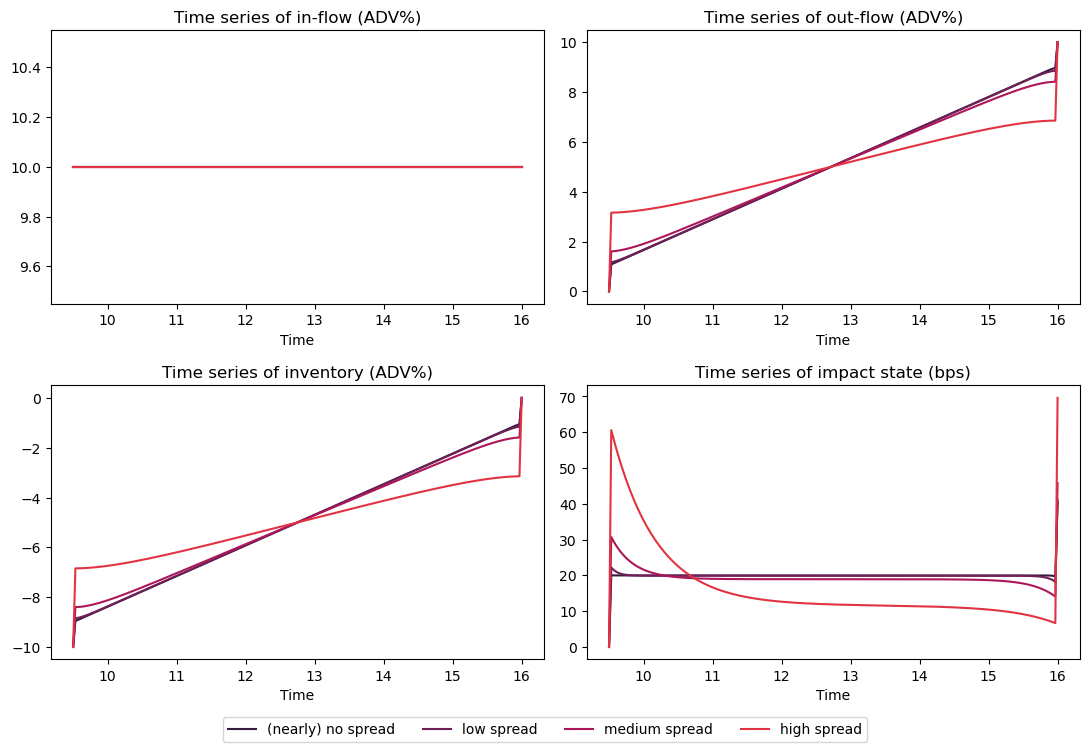

,Total variation of out-flow (ADV%),Terminal in-flow (ADV%),Terminal impact state (bps),Total variation of in-flow (ADV%),Sqrt QV of in-flow (ADV%),Spread cost per in-flow (bps),Impact cost per in-flow (bps),Total cost per in-flow (bps),Spread cost,Impact cost,Total cost,Closing trade as a percent of out-flow (%),Internalization (%),Out-flow TV over in-flow sqrtQV (%),Internalization regret (%),Impact to spread ratio,Continuous trading as a percent of out-flow (%)
parameter scans,,,,,,,,,,,,,,,,,
(nearly) no spread,10.0,10.0,40.4,10.0,10.0,0.0,21.1,21.1,0.0,0.0,0.0,10.3,0.0,100.0,0.0,668.2,79.2
low spread,10.0,10.0,41.1,10.0,10.0,0.3,21.3,21.7,0.0,0.0,0.0,11.4,0.0,100.0,0.0,70.8,77.0
medium spread,10.0,10.0,45.8,10.0,10.0,2.4,22.8,25.2,0.0,0.0,0.0,15.9,0.0,100.0,0.0,9.4,68.2
high spread,10.0,10.0,69.6,10.0,10.0,7.5,36.9,44.4,0.0,0.0,0.0,31.5,0.0,100.0,0.0,4.9,37.0


In [2]:
#first, let's check the behavior in the deterministic case, scanning across eps
eps = [1e-4, 1e-3, 1e-2, 0.1]
names = ['(nearly) no spread', 'low spread', 'medium spread', 'high spread']

parameters = generate_parameters(eps = eps, sigma = [0.0])
summary_stats, timeseries_df, df, N = simulate(parameters)

#colors = ["#BA55D3", "#4B0082", "#DC143C", "#8B0000"] # MediumOrchid, Indigo, Crimson, DarkRed
hue_order = names
sns.set_palette("rocket")

param_map = pd.DataFrame({'parameter scans': names, 'eps': eps})
params = parameters.merge(param_map, on=['eps'])
params['parameter scans'] = pd.Categorical(params['parameter scans'], categories=names, ordered=True)
stats_output, ts_output = beautify(params, summary_stats, timeseries_df, N)
plot_timeseries(ts_output, sample_id = 0, hue_order=hue_order, pathToSave="test.png") #figure 1


display(summarize_stats(stats_output).sort_values('parameter scans')) #table 1

sns.set_palette(None)

# Figure 1: Illustration of two extreme trading paths

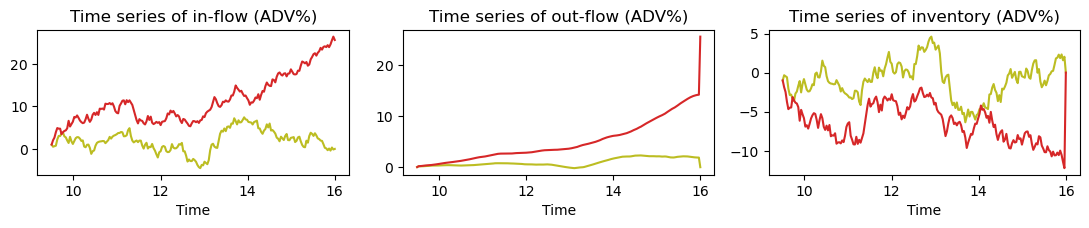

In [3]:
parameters = generate_parameters(z = [0.01])
summary_stats, timeseries_df, df, N = simulate(parameters, N = int(2000/speed_up_factor), nSamples=int(1000/speed_up_factor), nShocks = 200)

stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output['Terminal in-flow over TV of in-flow (%)'] = stats_output['Terminal in-flow (ADV%)'] / stats_output['Total variation of in-flow (ADV%)'] * 100

stats_output = stats_output.sort_values(by='Terminal in-flow over TV of in-flow (%)', ascending=False)
#create a dataframe with samples and sample names
samples = stats_output.iloc[[np.ceil(0.01*len(stats_output)-1),  len(stats_output)-1]]['sample_id'].values
samples = pd.DataFrame({'sample': ['Optimal execution path', 'Market making path'],
                       'sample_id': samples})

colors = [oliveHex, redHex]
hue_order = ['Market making path', 'Optimal execution path']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 2))
axes = axes.flatten()
#subset ts_output to only include the selected samples
ts_output = ts_output[ts_output['sample_id'].isin(samples['sample_id'].values)]
ts_output = ts_output.merge(samples, on='sample_id')

for ax, variable in zip(axes, ['in-flow (ADV%)', 'out-flow (ADV%)', 'inventory (ADV%)']):
    sns.lineplot(data=ts_output, x='time', y=variable, hue='sample', hue_order=hue_order, palette=colors, ax=ax)
    ax.set_title(f'Time series of {variable}')
    ax.set_xlabel('Time')
    ax.set_ylabel(None)
    ax.get_legend().remove()

handles, labels = axes[0].get_legend_handles_labels()

plt.tight_layout()
plt.subplots_adjust(bottom=0.10) 
plt.show()

# Figure 2, 3, 4: Sensitivity to $\theta$

In [4]:
# simulate paths
# scan across different theta values to showcase the in-flow dynamics
stats = ['Total variation of in-flow (ADV%)', 'Internalization (%)', 'Impact cost per in-flow (bps)', 'Total variation of out-flow (ADV%)',  'Internalization regret (%)', 'Spread cost per in-flow (bps)']

parameters = generate_parameters(theta = thetas)
summary_stats, timeseries_df, df, N = simulate(parameters, nSamples=int(5000/speed_up_factor))
params = parameters.merge(flow_map, on=['theta'])
stats_output, ts_output = beautify(params, summary_stats, timeseries_df, N)

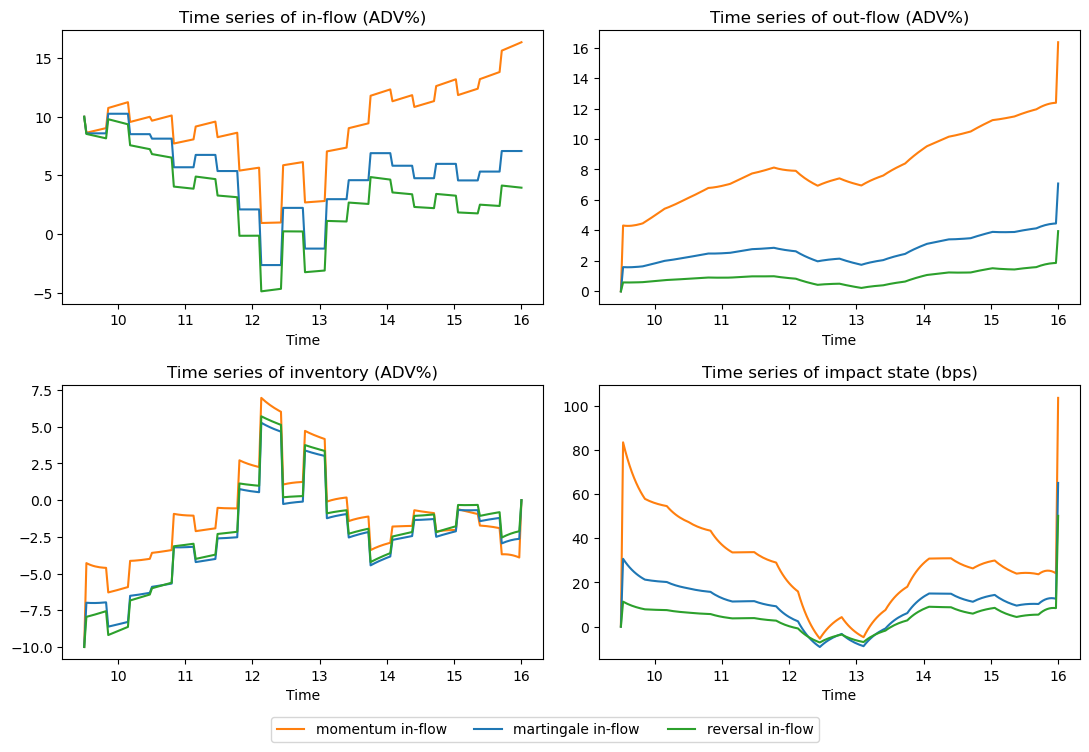

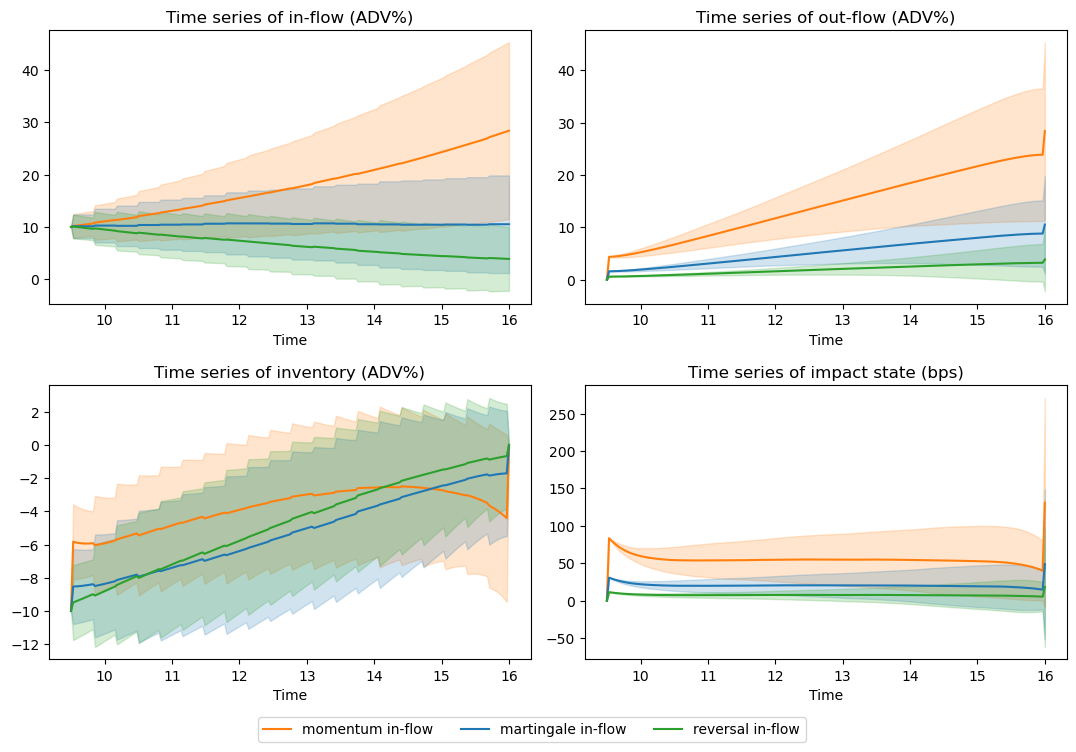

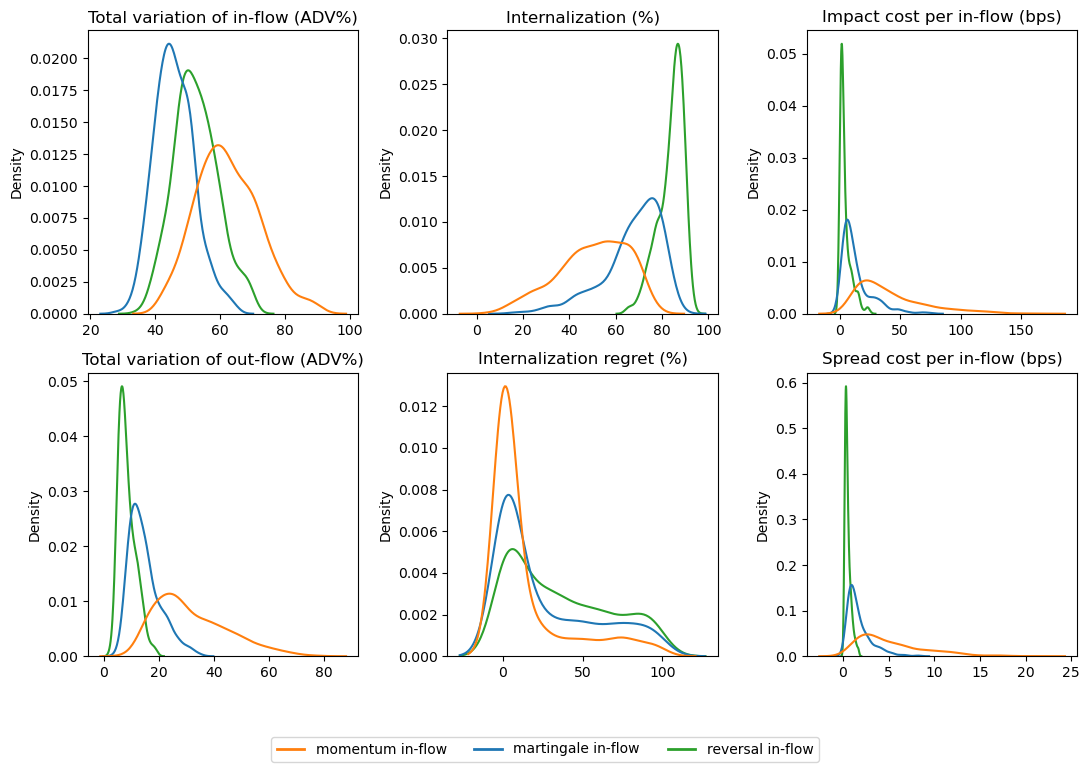

,Total variation of out-flow (ADV%),Terminal in-flow (ADV%),Terminal impact state (bps),Total variation of in-flow (ADV%),Sqrt QV of in-flow (ADV%),Spread cost per in-flow (bps),Impact cost per in-flow (bps),Total cost per in-flow (bps),Spread cost,Impact cost,Total cost,Closing trade as a percent of out-flow (%),Internalization (%),Out-flow TV over in-flow sqrtQV (%),Internalization regret (%),Impact to spread ratio,Continuous trading as a percent of out-flow (%)
parameter scans,,,,,,,,,,,,,,,,,
momentum in-flow,31.8,29.0,158.0,62.3,14.2,5.2,41.7,46.9,0.0,0.0,0.0,16.5,50.2,223.4,14.0,8.6,67.3
martingale in-flow,14.8,11.7,89.8,45.9,14.1,1.7,13.8,15.5,0.0,0.0,0.0,21.0,67.4,104.9,26.5,7.9,66.7
reversal in-flow,8.5,5.8,66.1,52.5,14.1,0.5,4.5,5.0,0.0,0.0,0.0,27.5,84.0,59.7,36.0,8.1,64.6


In [5]:
# figures 2, 3, 4 and table 2
colors = [orangeHex, blueHex, greenHex]
hue_order = ["momentum in-flow", "martingale in-flow", "reversal in-flow"]
bins = 15 #not used
plot_timeseries(ts_output, 0, colors, hue_order) #figure 2

plot_timeseries(ts_output, None, colors, hue_order) #figure 3

plot_distr(stats_output, stats = stats, bins=bins, colors=colors, hue_order=hue_order) #figure 4
display(summarize_stats(stats_output).loc[hue_order,:]) #table 2


In [6]:
# print some quantiles of the internalization regret

stat_name = "Internalization regret (%)"
thresholds = [0, .1, .2, .5, 1, 2, 5, 10]

for threshold in thresholds:
    substats_output = stats_output[stats_output[stat_name] <= threshold]

    counts = substats_output.groupby(["parameter scans"]).count().iloc[:,0]
    sample_size = stats_output.groupby(["parameter scans"]).count().iloc[:,0]
    prob_of_internalization_regret_is_zero = counts / sample_size * 100
    print(f"probability below {threshold}%")
    print(prob_of_internalization_regret_is_zero[hue_order])
    print('')


probability below 0%
parameter scans
momentum in-flow      23.2
martingale in-flow    12.4
reversal in-flow       4.6
Name: sample_id, dtype: float64

probability below 0.1%
parameter scans
momentum in-flow      32.8
martingale in-flow    15.6
reversal in-flow       7.6
Name: sample_id, dtype: float64

probability below 0.2%
parameter scans
momentum in-flow      36.6
martingale in-flow    17.0
reversal in-flow       8.8
Name: sample_id, dtype: float64

probability below 0.5%
parameter scans
momentum in-flow      42.2
martingale in-flow    21.0
reversal in-flow      10.8
Name: sample_id, dtype: float64

probability below 1%
parameter scans
momentum in-flow      46.4
martingale in-flow    23.6
reversal in-flow      12.2
Name: sample_id, dtype: float64

probability below 2%
parameter scans
momentum in-flow      55.4
martingale in-flow    29.4
reversal in-flow      16.4
Name: sample_id, dtype: float64

probability below 5%
parameter scans
momentum in-flow      65.4
martingale in-flow    40

# Figure 10: Scan across eps (and theta)

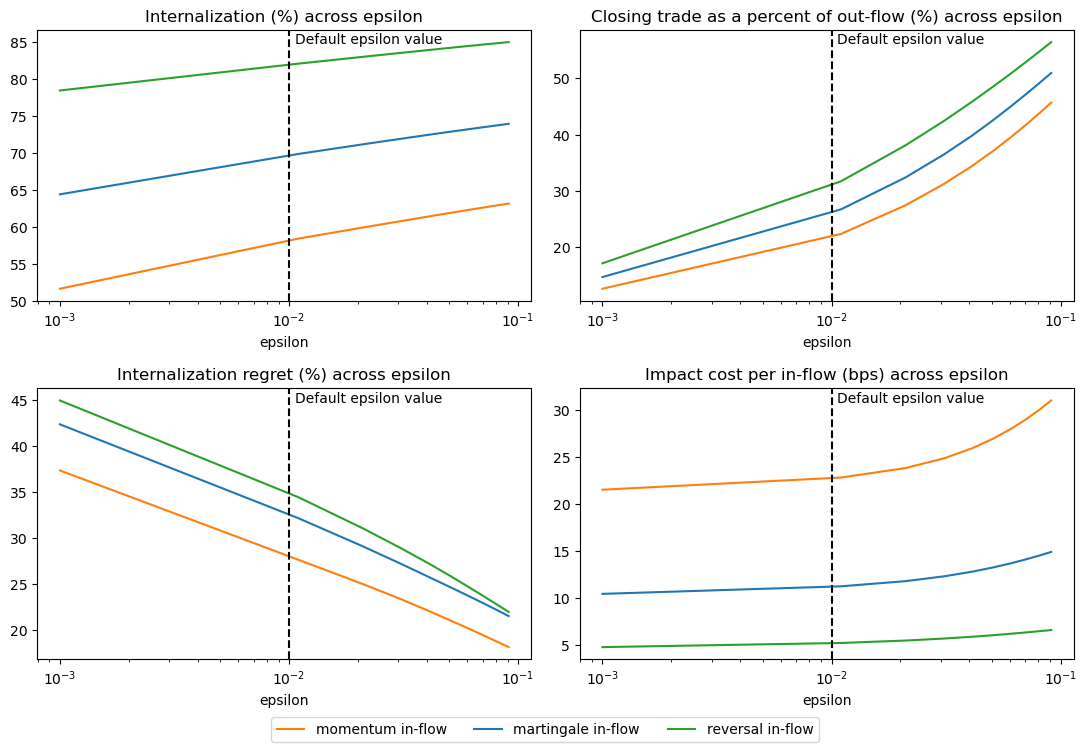

In [7]:
# figure 10 deeper scan of eps and theta with stochastic flow to illustrate internalization and closing trading

eps = np.arange(1, 100, 1*speed_up_factor)/1000
parameters = generate_parameters(eps = eps, theta = thetas, z = [0.0])
summary_stats, timeseries_df, df, N = simulate(parameters)
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output = stats_output.groupby(['eps', 'theta']).mean(numeric_only = True).reset_index()
stats_output = stats_output.merge(flow_map, on = ['theta'], how = 'left')

colors = [orangeHex, blueHex, greenHex]
hue_order = ["momentum in-flow", "martingale in-flow", "reversal in-flow"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
axes = axes.flatten()    
for ax, variable in zip(axes, ['Internalization (%)', 'Closing trade as a percent of out-flow (%)', 'Internalization regret (%)', 'Impact cost per in-flow (bps)']):
    ax.set_xscale('log')
    sns.lineplot(data=stats_output, x='eps', y=variable, hue='parameter scans', ax=ax, 
                 hue_order=hue_order, palette=colors)
    ax.set_title(f'{variable} across epsilon')
    ax.set_xlabel('epsilon')
    ax.set_ylabel(None)
    ax.axvline(x=0.01, linestyle='--', color='black')
    ax.text(0.0106, ax.get_ylim()[1]-0.4, 'Default epsilon value', verticalalignment='top')
    ax.legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, title=None, loc='center', bbox_to_anchor=(0.5, -0.05), ncol = len(handles))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05) 
plt.show()

# Figure 6: Deep scan of sigma

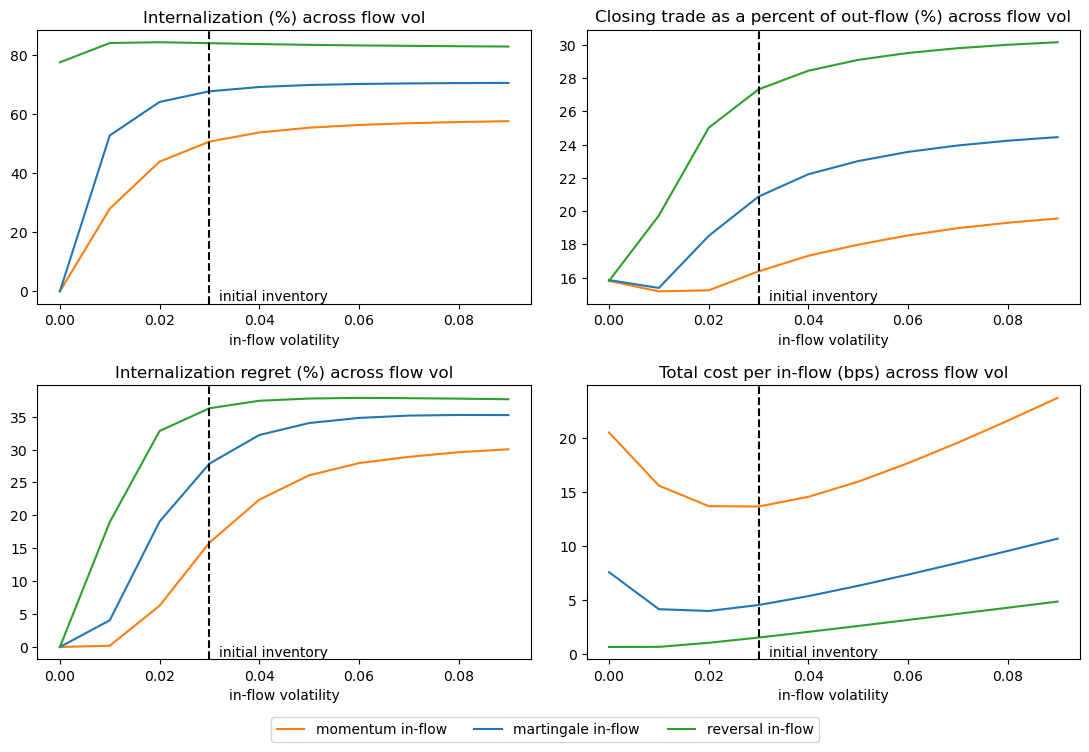

In [8]:
#deep scan of sigma to illustrate the regime transition from optimal execution to market making

sigmas = np.arange(0, 100, 1*speed_up_factor)/1000
parameters = generate_parameters(z=[0.03], theta = thetas, sigma = sigmas)
summary_stats, timeseries_df, df, N = simulate(parameters)
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output = stats_output.groupby(['sigma', 'theta']).mean(numeric_only = True).reset_index()
stats_output = stats_output.merge(flow_map, on = ['theta'], how = 'left')

colors = [orangeHex, blueHex, greenHex]
hue_order = ["momentum in-flow", "martingale in-flow", "reversal in-flow"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
axes = axes.flatten()    
for ax, variable in zip(axes, ['Internalization (%)', 'Closing trade as a percent of out-flow (%)', 'Internalization regret (%)', 'Total cost per in-flow (bps)']):
    sns.lineplot(data=stats_output, x='sigma', y=variable, hue='parameter scans', ax=ax,
                hue_order=hue_order, palette=colors, )
    ax.set_title(f'{variable} across flow vol')
    ax.set_xlabel('in-flow volatility')
    ax.set_ylabel(None)
    ax.axvline(x=0.03, linestyle='--', color='black')
    ax.text(0.032, ax.get_ylim()[0], 'initial inventory', verticalalignment='bottom')
    ax.legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, title=None, loc='center', bbox_to_anchor=(0.5, -0.05), ncol = len(handles))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05) 
plt.show()

# Figure 12: Initial impact state

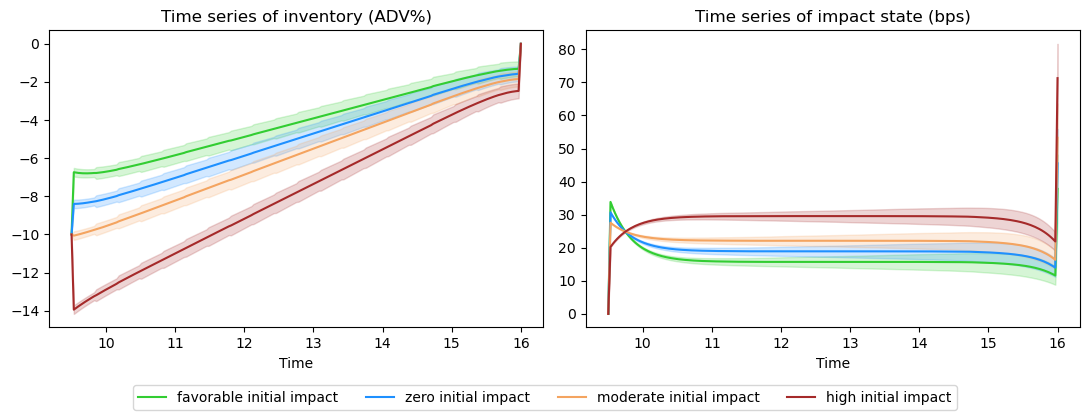

In [9]:
# figure 12 small scale parameter scan over the initial impact state to showcase that one can trade on reversion if the initial impact is too high
ys = [-0.003, 0.0, 0.003, 0.01]
names = ['favorable initial impact', 'zero initial impact', 'moderate initial impact', 'high initial impact']
stats = ['Total variation of in-flow (ADV%)', 'Internalization (%)', 'Spread cost per in-flow (bps)', 'Total variation of out-flow (ADV%)',  'Closing trade as a percent of out-flow (%)', 'Impact cost per in-flow (bps)']
hue_order = names
colors = ["LimeGreen", "DodgerBlue", "SandyBrown", "Brown"]

parameters = generate_parameters(y = ys, sigma = [0.01])
summary_stats, timeseries_df, df, N = simulate(parameters)

param_map = pd.DataFrame({'parameter scans': names,'y': ys})
params = parameters.merge(param_map, on=['y'])
stats_output, ts_output = beautify(params, summary_stats, timeseries_df, N)
plot_timeseries(ts_output, None, colors=colors, hue_order=hue_order,
                variables=['inventory (ADV%)', 'impact state (bps)'],
               bbox_to_anchor_up_down = -0.15)
#plot_distr(stats_output, stats = stats, colors=colors, hue_order=hue_order)
#display(summarize_stats(stats_output))


# Additional heat map, sensitivity to joint initial conditions (not in paper)

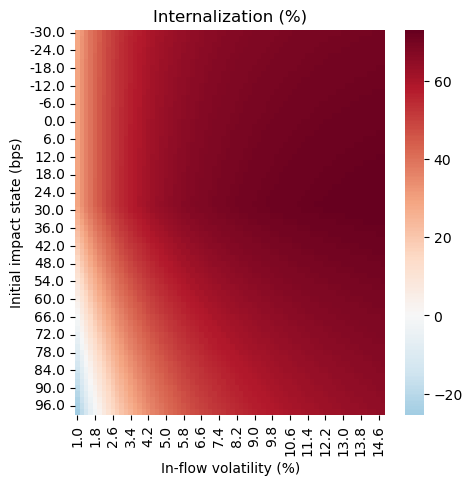

In [10]:
#large scale heat map to show sensitivity to joint initial conditions
sigmas = np.arange(10, 150, 2)/1000
ys = np.arange(-30, 100, 2)/10000
stats = ['Internalization (%)']

parameters = generate_parameters(y = ys, sigma = sigmas)
summary_stats, timeseries_df, df, N = simulate(parameters, nSamples=50, N=50) #need to downsize the simulation to avoid memory error given the large number of parameters 
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output = stats_output.groupby(['y', 'sigma']).mean(numeric_only = True).reset_index()
stats_output['Initial impact state (bps)'] = round(stats_output['y']*10000)
stats_output['In-flow volatility (%)'] = round(stats_output['sigma'] * 100, 1)

for stat in stats:
    fig, ax = plt.subplots(figsize = (5, 5))
    sns.heatmap(stats_output.pivot(index='Initial impact state (bps)', columns='In-flow volatility (%)', values=stat), ax = ax, cmap = 'RdBu_r', center = 0)
    ax.set_title(stat)
    ax.set_xlabel('In-flow volatility (%)')
    ax.set_ylabel('Initial impact state (bps)')
    plt.show()

# Figure 7: Path monotonicity

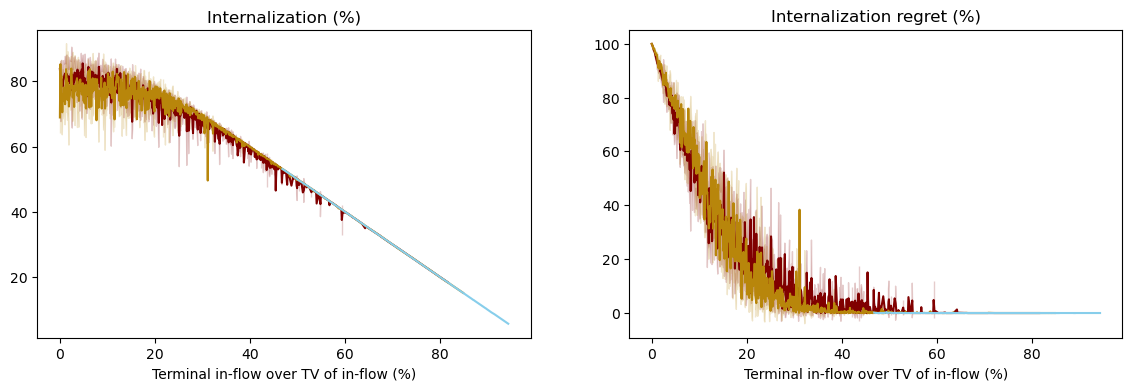

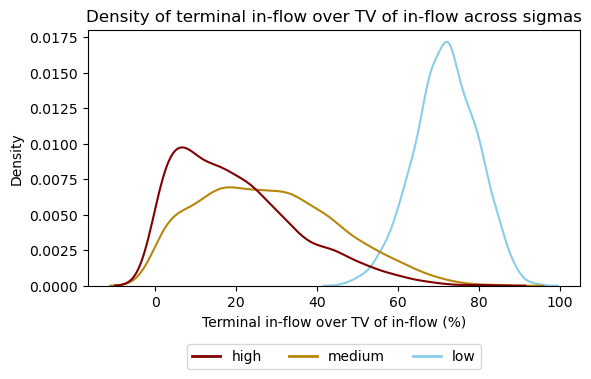

In [11]:
# figure 7 path monotonicity

sigmas = [0.01, 0.07, 0.2]
mapping = {0.01: 'low', 0.07: 'medium', 0.2: 'high'}
stats = ['Internalization (%)', 'Internalization regret (%)']
parameters = generate_parameters(sigma=sigmas)
summary_stats, timeseries_df, df, N = simulate(parameters, nSamples=int(200000/speed_up_factor**2), N=50) #need to downsize the simulation to avoid memory error given the large number of parameters 

stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output['In-flow volatility (%)'] = round(stats_output['sigma'] * 100, 1)
stats_output['Terminal in-flow over TV of in-flow (%)'] = round(stats_output['Terminal in-flow (ADV%)'] / stats_output['Total variation of in-flow (ADV%)'] * 100, 1)
stats_output.loc[:,'sigma'] = stats_output['sigma'].replace(mapping)

hue_order = ["high", "medium", "low"]
colors = ["Maroon", "DarkGoldenrod", "SkyBlue"]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axs = axs.flatten()    
for ax, variable in zip(axs, stats):
    sns.lineplot(data=stats_output, x='Terminal in-flow over TV of in-flow (%)', 
                 y=variable, hue='sigma', 
                 hue_order=hue_order, palette=colors, ax=ax, errorbar='sd')
    ax.set_xlabel('Terminal in-flow over TV of in-flow (%)')
    ax.set_ylabel(None)
    ax.set_title(variable)
    ax.get_legend().remove()
plt.show()

#plot density of terminal in-flow over TV of in-flow across thetas
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(data=stats_output, x="Terminal in-flow over TV of in-flow (%)",
           hue="sigma", hue_order=hue_order, palette=colors, ax=ax)

ax.set_xlabel('Terminal in-flow over TV of in-flow (%)')
ax.set_ylabel('Density')
ax.set_title('Density of terminal in-flow over TV of in-flow across sigmas')
ax.get_legend().remove()
legend_lines = [plt.Line2D([0], [0], color=color, linewidth=2) for color in colors]
legend_labels = hue_order
ax.legend(legend_lines, legend_labels, title=None, loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol = len(colors))
plt.tight_layout()
plt.show()

# Figure 11: Diffusive limit for in-flow

In [12]:
%%time
#diffusive limit for in-flow
#splitting computation and plotting into separate cells to allow faster plot iteration 

parameters = generate_parameters(theta = thetas)

def loop(N):
    summary_stats, timeseries_df, df, N = simulate(parameters, nShocks= N, N = N, nSamples= int(5000/speed_up_factor**2))
    stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
    stats_output = stats_output.groupby('theta').mean(numeric_only = True).reset_index()
    stats_output['Number of shocks'] = N
    return stats_output

stats_output = pd.DataFrame()
#for N in [10*(2**i) for i in range(1, 12)]:
for N in [10*(2**i) for i in range(1, 11)]:
    stats_output = pd.concat([stats_output, loop(N)])
stats_output = stats_output.reset_index(drop=True)
stats_output = stats_output.merge(flow_map, on=['theta'])

CPU times: total: 6.3 s
Wall time: 6.47 s


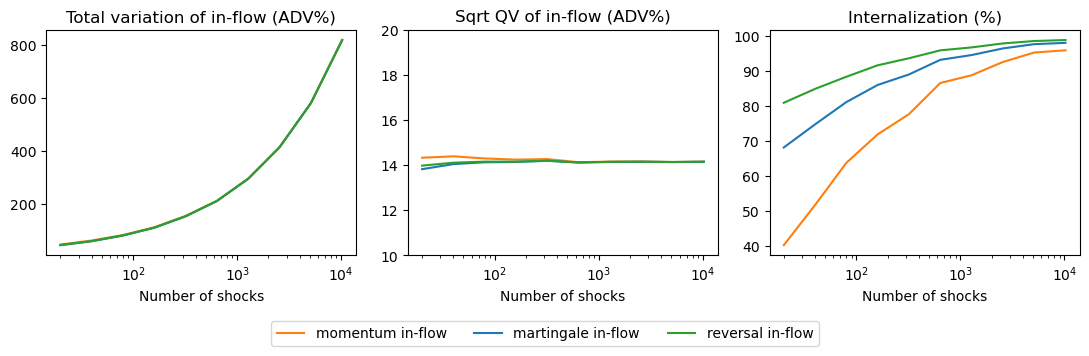

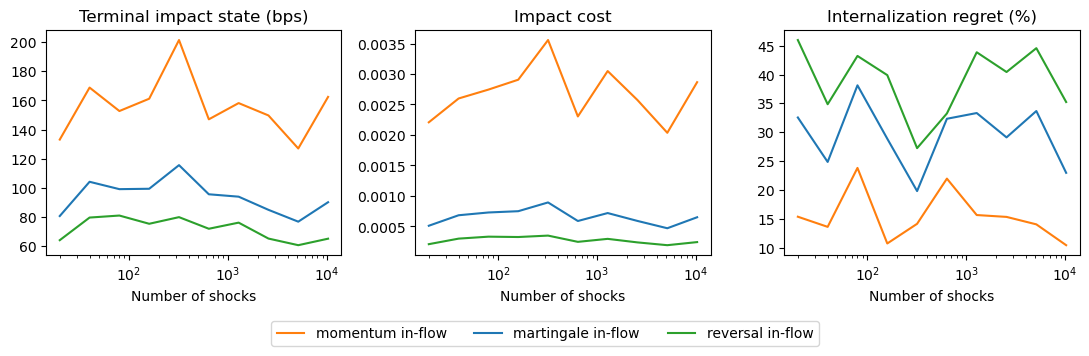

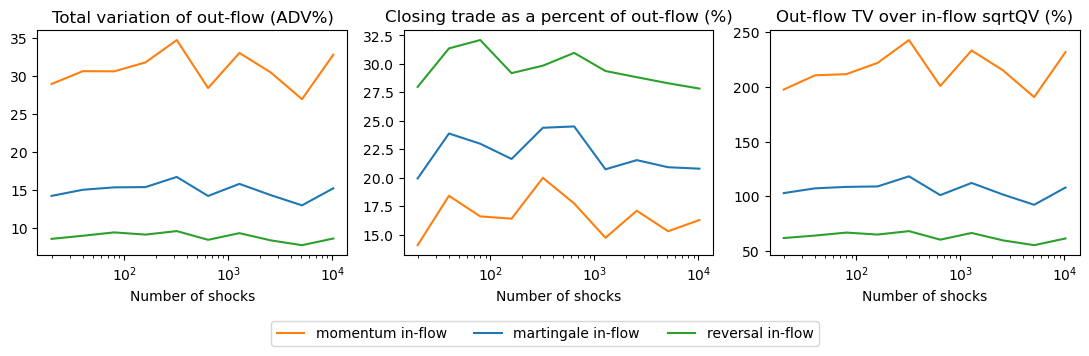

In [13]:
#plotting for previous (expensive) code chunk
def display_plots(stats, special_ylim=None):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
    axs = axs.flatten()    
    
    colors = [orangeHex, blueHex, greenHex]
    hue_order = ["momentum in-flow", "martingale in-flow", "reversal in-flow"]
    
    for i, (ax, variable) in enumerate(zip(axs, stats)):
        sns.lineplot(data=stats_output, x='Number of shocks', y=variable, hue='parameter scans', 
                     hue_order=hue_order, palette=colors, ax=ax)
        ax.set_title(variable)
        ax.set_xscale('log')
        ax.set_xlabel('Number of shocks')
        ax.set_ylabel(None)
        ax.legend().remove()
        
        if special_ylim is not None and i == 1:
            ax.set_ylim(special_ylim[0], special_ylim[1])
        

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, title=None, loc='center', bbox_to_anchor=(0.5, -0.13), ncol = len(handles))

    plt.tight_layout() 
    plt.subplots_adjust(bottom=0.13) 
    plt.show()

stats = ['Total variation of in-flow (ADV%)', 'Sqrt QV of in-flow (ADV%)', 'Internalization (%)']
fig = display_plots(stats, (10,20)) #figure 11(a)


stats = ['Terminal impact state (bps)', 'Impact cost', 'Internalization regret (%)']
display_plots(stats) #figure 11(b)

stats = ['Total variation of out-flow (ADV%)', 'Closing trade as a percent of out-flow (%)', 'Out-flow TV over in-flow sqrtQV (%)']
display_plots(stats) #figure 11(c)

# Figure 5: Total cost distribution conditional on internalization

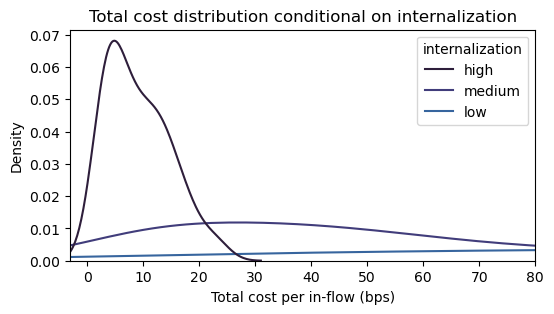

In [14]:
sigmas = np.arange(1, 15, 2)/10
thetas = np.arange(-10, 10, 2)/10

parameters = generate_parameters(sigma=sigmas)
summary_stats, timeseries_df, df, N = simulate(parameters, nSamples=int(10000/speed_up_factor**2), N=50) #need to downsize the simulation to avoid memory error given the large number of parameters 

stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)
stats_output['In-flow volatility (%)'] = stats_output['sigma'] * 100

hue_order = ['high', 'medium', 'low']
#colors = ['DarkGreen', 'MediumSeaGreen', 'Orchid']
sns.set_palette("mako")

stats_output.loc[np.abs(stats_output['Internalization (%)'] - 60) < 5, 'internalization'] = 'low'
stats_output.loc[np.abs(stats_output['Internalization (%)'] - 75) < 5, 'internalization'] = 'medium'
stats_output.loc[np.abs(stats_output['Internalization (%)'] - 90) < 5, 'internalization'] = 'high'

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data = stats_output, x='Total cost per in-flow (bps)', hue = 'internalization', 
            hue_order=hue_order, ax=ax, common_norm = False)
ax.set_xlabel('Total cost per in-flow (bps)')
ax.set_ylabel('Density')
ax.set_title('Total cost distribution conditional on internalization')
ax.set_xlim([-3, 80])
plt.show()

sns.set_palette(None)

# Figure 8: Misspecification costs

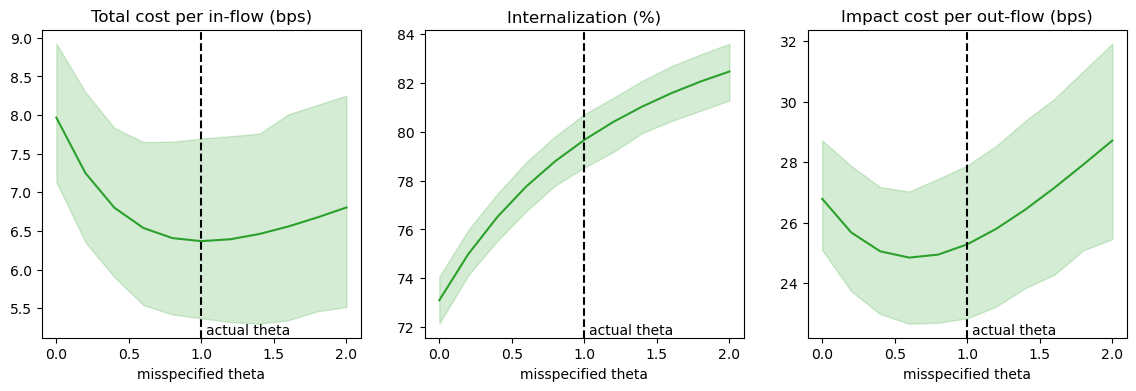

In [15]:
#misspecification costs
true_theta = 1.0
color = greenHex
#symmetric range around true_theta
thetas = np.arange(-100, 102, 2*speed_up_factor)/100 + true_theta

parameters = generate_parameters(theta =thetas)
parameters['misspecified theta'] = parameters['theta'].copy()
T, N, nSamples, nShocks = 1.0, int(200/speed_up_factor), int(2000/speed_up_factor), int(200/speed_up_factor)
parameters = add_auxiliary_variables(parameters)
df, T, N, dt = add_time_grid(parameters, T, N)
df, T = add_helper_variables(df, T)
parameters['theta'] = true_theta
df['theta'] = true_theta
summary_stats, timeseries_df = simulate_path(df, dt, N, nSamples, nShocks)
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)

stats_output['Impact cost per out-flow (bps)'] = stats_output['Total cost per in-flow (bps)']*stats_output['Total variation of in-flow (ADV%)']/stats_output['Total variation of out-flow (ADV%)']
stats = ['Total cost per in-flow (bps)', 'Internalization (%)', 'Impact cost per out-flow (bps)']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs = axs.flatten()    
for ax, variable in zip(axs, stats):
    sns.lineplot(data=stats_output, x='misspecified theta', y=variable, ax=ax, color=color) #, errorbar='sd')
    ax.set_xlabel('misspecified theta')
    ax.set_ylabel(None)
    ax.set_title(variable)
    ax.axvline(x=true_theta, linestyle='--', color='black')
    ax.text(true_theta + 0.03, ax.get_ylim()[0], 'actual theta', verticalalignment='bottom')
plt.show()

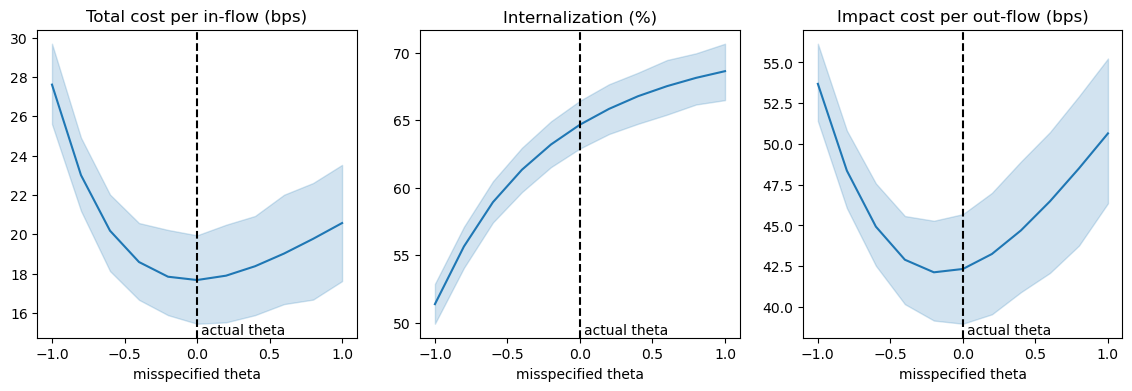

In [16]:
#misspecification costs
true_theta = 0.0
color = blueHex
#symmetric range around true_theta
thetas = np.arange(-100, 102, 2*speed_up_factor)/100 + true_theta

parameters = generate_parameters(theta =thetas)
parameters['misspecified theta'] = parameters['theta'].copy()
T, N, nSamples, nShocks = 1.0, int(200/speed_up_factor), int(2000/speed_up_factor), int(200/speed_up_factor)

parameters = add_auxiliary_variables(parameters)
df, T, N, dt = add_time_grid(parameters, T, N)
df, T = add_helper_variables(df, T)
parameters['theta'] = true_theta
df['theta'] = true_theta
summary_stats, timeseries_df = simulate_path(df, dt, N, nSamples, nShocks)
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)

stats_output['Impact cost per out-flow (bps)'] = stats_output['Total cost per in-flow (bps)']*stats_output['Total variation of in-flow (ADV%)']/stats_output['Total variation of out-flow (ADV%)']
stats = ['Total cost per in-flow (bps)', 'Internalization (%)', 'Impact cost per out-flow (bps)']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs = axs.flatten()    
for ax, variable in zip(axs, stats):
    sns.lineplot(data=stats_output, x='misspecified theta', y=variable, ax=ax, color=color) #, errorbar='sd')
    ax.set_xlabel('misspecified theta')
    ax.set_ylabel(None)
    ax.set_title(variable)
    ax.axvline(x=true_theta, linestyle='--', color='black')
    ax.text(true_theta + 0.03, ax.get_ylim()[0], 'actual theta', verticalalignment='bottom')
plt.show()

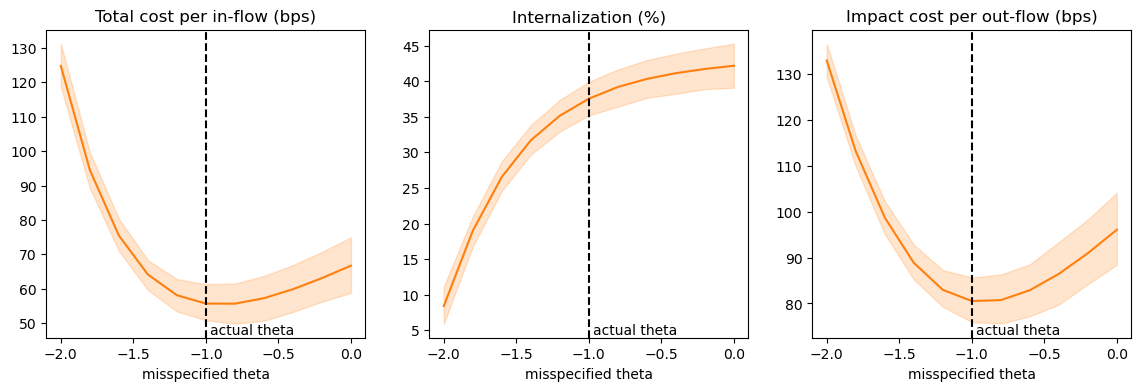

In [17]:
#misspecification costs
true_theta = -1.0
color = orangeHex
#symmetric range around true_theta
thetas = np.arange(-100, 102, 2*speed_up_factor)/100 + true_theta

parameters = generate_parameters(theta =thetas)
parameters['misspecified theta'] = parameters['theta'].copy()
T, N, nSamples, nShocks = 1.0, int(200/speed_up_factor), int(2000/speed_up_factor), int(200/speed_up_factor)
parameters = add_auxiliary_variables(parameters)
df, T, N, dt = add_time_grid(parameters, T, N)
df, T = add_helper_variables(df, T)
parameters['theta'] = true_theta
df['theta'] = true_theta
summary_stats, timeseries_df = simulate_path(df, dt, N, nSamples, nShocks)
stats_output, ts_output = beautify(parameters, summary_stats, timeseries_df, N)

stats_output['Impact cost per out-flow (bps)'] = stats_output['Total cost per in-flow (bps)']*stats_output['Total variation of in-flow (ADV%)']/stats_output['Total variation of out-flow (ADV%)']
stats = ['Total cost per in-flow (bps)', 'Internalization (%)', 'Impact cost per out-flow (bps)']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs = axs.flatten()    
for ax, variable in zip(axs, stats):
    sns.lineplot(data=stats_output, x='misspecified theta', y=variable, ax=ax, color=color) #, errorbar='sd')
    ax.set_xlabel('misspecified theta')
    ax.set_ylabel(None)
    ax.set_title(variable)
    ax.axvline(x=true_theta, linestyle='--', color='black')
    ax.text(true_theta + 0.03, ax.get_ylim()[0], 'actual theta', verticalalignment='bottom')
plt.show()

# Figure 13: Empirical Theta

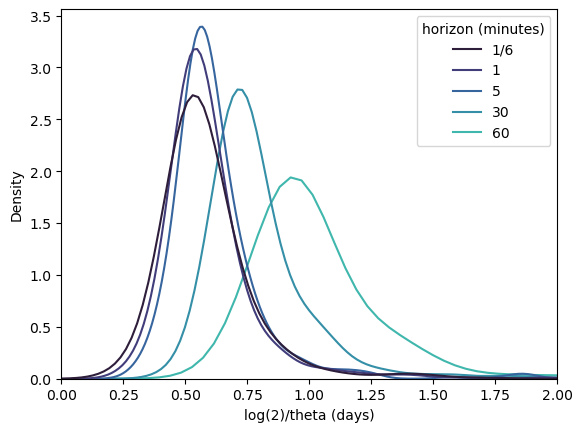

In [22]:
hue_order = ["1/6", "1", "5", "30", "60"]
#colors = ["SeaGreen", "DodgerBlue", "MediumSlateBlue", "Indigo", "OrangeRed"]
x_name = "log(2)/theta (days)"
hue_name = "horizon (minutes)"
sns.set_palette("mako")

df = pd.read_csv("empiricalTheta.csv")
df[x_name] = np.log(2) / df.theta / (60 * 6.5) # from minute to day, where a day has 60 * 6.5 trading minutes

mapping = {'0.1666667': '1/6', '1.0': '1', '5.0': '5', '30.0' : '30', '60.0' : '60'}
df.loc[:,hue_name] = df['horizon'].astype(str).replace(mapping)

fig = sns.kdeplot(data=df, x=x_name, hue=hue_name, hue_order=hue_order, common_norm=False)

fig.set_xlim([0, 2]);

sns.set_palette(None)